# Intervention des pompiers de Montreal
Ce notebook presente les données concernant les interventions des pompiers de Montréal

## Preparation des données

In [297]:
import requests
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import pathlib
%matplotlib inline
mpl.rcParams['figure.figsize'] = 20,10

In [298]:
%%capture
# !pip install requests tqdm jupyterlab_widgets ipywidgets;
# !jupyter nbextension enable --py widgetsnbextension;
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager;

In [299]:
def download_stuff(name, url, path):
    """Download stuff nicely."""
    #TODO shunt only if too old
    print(f"Downloading {name}...")
    if pathlib.Path(path).exists():
        print("Already available.")
        return
    response = requests.get(url, stream=True)
    response.raise_for_status()
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    block_size = 1024
    with open(path, "wb") as f:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            f.write(data)
    progress_bar.close()
# TODO auto download

download_stuff(
    "main dataset",
    "https://data.montreal.ca/dataset/2fc8a2b9-1556-410e-a118-c46e97e9f19e/resource/71e86320-e35c-4b4c-878a-e52124294355/download/donneesouvertes-interventions-sim.csv",
    "donneesouvertes-interventions-sim.csv"
)
download_stuff(
    "arrondissement dataset",
    "https://data.montreal.ca/dataset/00bd85eb-23aa-4669-8f1b-ba9a000e3dd8/resource/e9b0f927-8f75-458c-8fda-b5da65cc8b73/download/limadmin.geojson",
    "limadmin.geojson"
)
download_stuff(
    "population arrondissement dataset",
    "https://data.montreal.ca/dataset/476ed7db-684a-42a3-8028-8d6cb83c0ec3/resource/370b0c30-886a-435b-9049-bcc5a5dd2e80/download/population-quartiers-arrondissements-et-villes-liees.csv",
    "population-quartiers-arrondissements-et-villes-liees.csv"
)

Already available.
Already available.
Already available.


In [300]:
main_data = (
    pd.read_csv('donneesouvertes-interventions-sim.csv')
    .drop(["MTM8_X", "MTM8_Y"], axis=1)
)
main_data.columns = ["identifiant", "horodatage", "type_incident", "groupe_incident", "caserne", "ville", "arrondissement", "division", "nombre_unites", "civ", "longitude", "latitude"]
main_data["horodatage"] = pd.to_datetime(main_data["horodatage"])
for i in ["type_incident", "groupe_incident", "ville", "arrondissement"]:
    main_data[i] = main_data[i].astype('category')
main_data["horodatage_par_mois"] = main_data["horodatage"].dt.to_period('M')
# main_data

In [301]:
# main, geo, pop
rosetta_stone=[
    ("Ahuntsic / Cartierville", "Ahuntsic-Cartierville", "Ahuntsic-Cartierville"),
    ("Anjou", "Anjou", "Anjou"),
    ("Côte-des-Neiges / Notre-Dame-de-Grâce", "Côte-des-Neiges-Notre-Dame-de-Grâce", "Côte-des-Neiges–Notre-Dame-de-Grâce"),
    ("L'Ile-Bizard / Ste-Geneviève", "L'Île-Bizard-Sainte-Geneviève", "L'Île-Bizard–Sainte-Geneviève"),
    ("Lachine", "Lachine", "Lachine"),
    ("Lasalle", "LaSalle", "LaSalle"),
    ("Mercier / Hochelaga-Maisonneuve", "Mercier-Hochelaga-Maisonneuve", "Mercier–Hochelaga-Maisonneuve"),
    ("Montréal-Nord", "Montréal-Nord", "Montréal-Nord"),
    ("Outremont", "Outremont", "Outremont"),
    ("Pierrefonds / Roxboro", "Pierrefonds-Roxboro", "Pierrefonds-Roxboro"),
    ("Plateau Mont-Royal", "Le Plateau-Mont-Royal", "Le Plateau-Mont-Royal"),
    ("Rivière-des-Prairies / Pointe-aux-Trembles", "Rivière-des-Prairies-Pointe-aux-Trembles", "Rivière-des-Prairies–Pointe-aux-Trembles"),
    ("Rosemont / Petite-Patrie", "Rosemont-La Petite-Patrie", "Rosemont–La Petite-Patrie"),
    ("Saint-Laurent", "Saint-Laurent", "Saint-Laurent"),
    ("Saint-Léonard", "Saint-Léonard", "Saint-Léonard"),
    ("Sud-Ouest", "Le Sud-Ouest", "Le Sud-Ouest"),
    ("Verdun", "Verdun", "Verdun"),
    ("Ville-Marie", "Ville-Marie", "Ville-Marie"),
    ("Villeray / St-Michel / Parc Extension", "Villeray-Saint-Michel-Parc-Extension", "Villeray–Saint-Michel–Parc-Extension"),
]


In [302]:
arrondissement_geo = (
    gpd.read_file('limadmin.geojson')
    .drop(["ABREV", "NUM", "CODEMAMROT", "CODEID", "MUNID", "PERIM", "geometry"], axis=1)
    .query("TYPE == 'Arrondissement'")
    .drop(["TYPE"], axis=1)
)
arrondissement_geo.columns = ['arrondissement', 'aire']
arrondissement_geo["arrondissement_aire_km2"] = arrondissement_geo["aire"] / 10**6
arrondissement_geo.drop("aire", axis=1, inplace=True)
rosetta = {tup[1]:tup[0] for tup in rosetta_stone}
arrondissement_geo["arrondissement"] = arrondissement_geo["arrondissement"].map(lambda x: rosetta[x]).astype('category')
arrondissement_geo.set_index('arrondissement', inplace=True)
arrondissement_geo

,arrondissement_aire_km2
arrondissement,
Outremont,3.813356
Lasalle,25.197268
Ville-Marie,21.500632
Plateau Mont-Royal,8.151665
Sud-Ouest,18.144269
Rivière-des-Prairies / Pointe-aux-Trembles,50.047004
Lachine,23.127786
Montréal-Nord,12.430208
L'Ile-Bizard / Ste-Geneviève,36.532506


In [303]:
arrondissement_pop = pd.read_csv("population-quartiers-arrondissements-et-villes-liees.csv")
arrondissement_pop.columns = ["arrondissement", "todrop", "arrondissement_population"]
arrondissement_pop.drop("todrop", axis=1, inplace=True)
arrondissement_pop = arrondissement_pop[~arrondissement_pop["arrondissement_population"].isna()].copy()
rosetta = {tup[2]:tup[0] for tup in rosetta_stone}
arrondissement_pop["arrondissement"] = arrondissement_pop["arrondissement"].map(lambda x: rosetta.get(x))
arrondissement_pop = arrondissement_pop[~arrondissement_pop["arrondissement"].isna()].copy()
arrondissement_pop.set_index('arrondissement', inplace=True)
arrondissement_pop

,arrondissement_population
arrondissement,
Ahuntsic / Cartierville,126891.0
Anjou,41928.0
Côte-des-Neiges / Notre-Dame-de-Grâce,165031.0
Lachine,41616.0
Lasalle,74276.0
Plateau Mont-Royal,100390.0
Sud-Ouest,71546.0
L'Ile-Bizard / Ste-Geneviève,18097.0
Mercier / Hochelaga-Maisonneuve,131483.0


In [304]:
final_data = (
    main_data
    .join(arrondissement_geo, on="arrondissement", how='left')
    .join(arrondissement_pop, on="arrondissement", how='left')
)
final_data

,identifiant,horodatage,type_incident,groupe_incident,caserne,ville,arrondissement,division,nombre_unites,civ,longitude,latitude,horodatage_par_mois,arrondissement_aire_km2,arrondissement_population
0,86705,2015-09-04 19:10:09,Premier répondant,1-REPOND,39,Montréal,Mercier / Hochelaga-Maisonneuve,7,1.0,1.0,-73.554978,45.584080,2015-09,27.408412,131483.0
1,86708,2015-09-04 19:14:55,Premier répondant,1-REPOND,42,Montréal,Ahuntsic / Cartierville,3,1.0,1.0,-73.684908,45.535034,2015-09,25.571187,126891.0
2,85429,2015-09-01 15:10:25,Premier répondant,1-REPOND,40,Montréal,Mercier / Hochelaga-Maisonneuve,7,1.0,1.0,-73.526428,45.589196,2015-09,27.408412,131483.0
3,88502,2015-09-09 11:20:18,Appel de Cie de détection,Alarmes-incendies,29,Montréal,Rosemont / Petite-Patrie,7,4.0,1.0,-73.567874,45.543528,2015-09,15.886530,134038.0
4,88781,2015-09-10 08:28:35,Appel de Cie de détection,Alarmes-incendies,18,Montréal,Montréal-Nord,8,5.0,1.0,-73.621417,45.617192,2015-09,12.430208,83868.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681350,19933,2017-02-25 12:24:56,Premier répondant,1-REPOND,43,Montréal,Ahuntsic / Cartierville,3,NaN,1.0,-73.657790,45.571311,2017-02,25.571187,126891.0
681351,79138,2018-08-10 18:52:29,Premier répondant,1-REPOND,19,Montréal,Ville-Marie,6,NaN,NaN,-73.554818,45.519931,2018-08,21.500632,84013.0
681352,64734,2017-06-30 18:26:08,Premier répondant,1-REPOND,31,Montréal,Rosemont / Petite-Patrie,7,NaN,1.0,-73.615169,45.537523,2017-06,15.886530,134038.0
681353,72626,2017-07-21 11:33:40,Premier répondant,1-REPOND,59,Montréal,Pierrefonds / Roxboro,1,NaN,1.0,-73.934730,45.455409,2017-07,33.765273,68410.0


# evolution du nombre d'intervention

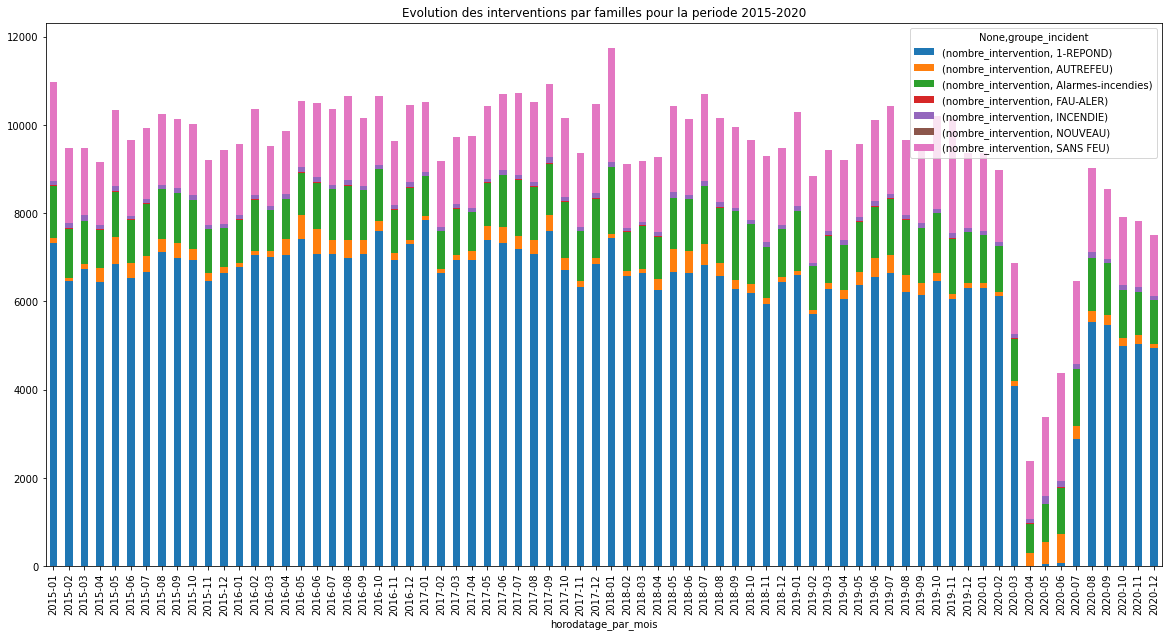

In [305]:
(final_data[["horodatage", "groupe_incident", "horodatage_par_mois"]]
 .groupby(["horodatage_par_mois", "groupe_incident"]).count()
 .rename(columns={'horodatage':"nombre_intervention"})
 .fillna(0)
).unstack().plot(kind="bar", stacked=True)
plt.title("Evolution des interventions par familles pour la periode 2015-2020")
plt.show()

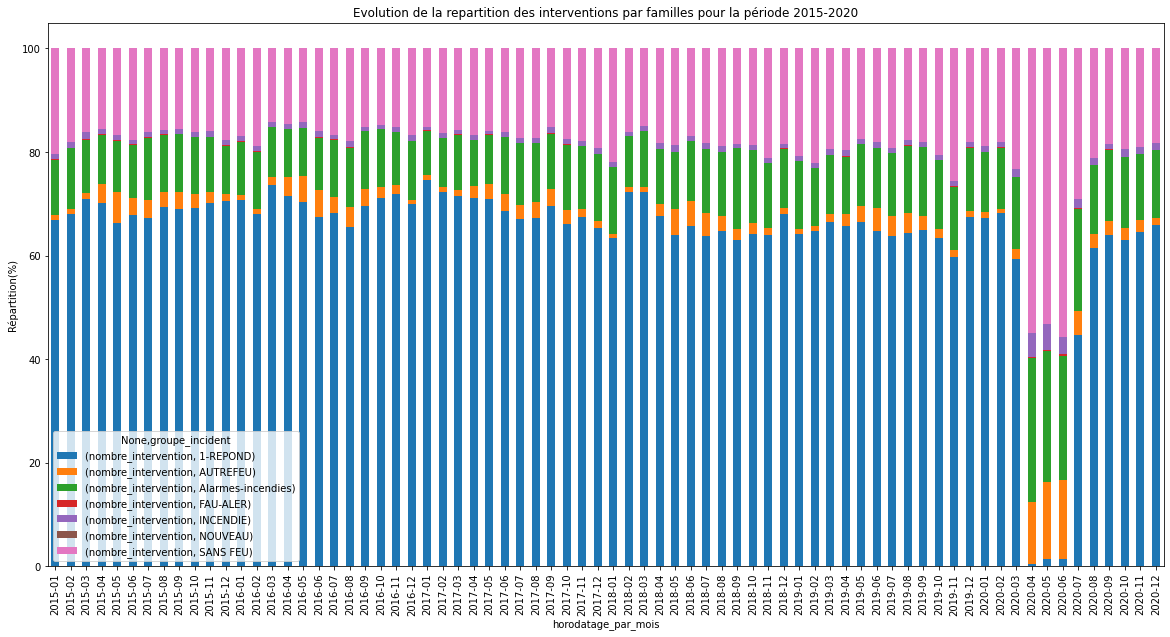

In [306]:
(final_data[["horodatage", "groupe_incident", "horodatage_par_mois"]]
 .groupby(["horodatage_par_mois", "groupe_incident"]).count()
 .rename(columns={'horodatage':"nombre_intervention"})
 .fillna(0)
).unstack().apply(lambda x: x / x.sum() * 100, axis=1).plot(kind="bar",stacked=True)
plt.title("Evolution de la repartition des interventions par familles pour la période 2015-2020")
plt.ylabel("Répartition(%)")
plt.show()

# Types d'incidents

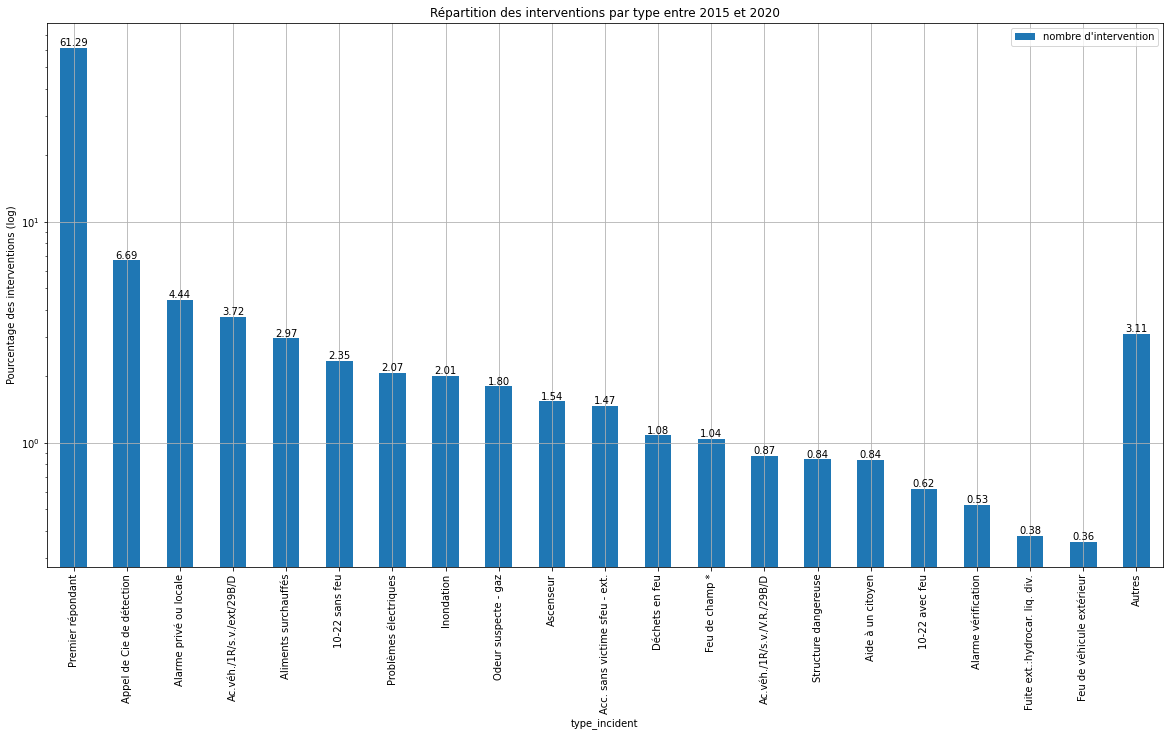

In [307]:
import numpy as np
nb_type_to_display = 20
data = (
    final_data[['horodatage', 'type_incident']]
    .groupby('type_incident').count()
    .rename(columns={"horodatage": "nombre d'intervention"})
    .sort_values("nombre d'intervention", ascending=False)
).copy()
data = data / data.sum(axis=0) * 100
data.set_index(data.index.add_categories("Autres"), inplace=True)
autres = data[20:].sum(axis=0)
data.drop(data.index[20:], axis=0, inplace=True)
data.loc["Autres"] = autres
data.plot(kind="bar")
plt.yscale("log")
plt.ylabel("Pourcentage des interventions (log)")
plt.title("Répartition des interventions par type entre 2015 et 2020")
plt.grid()
for i,v in enumerate(data.apply(lambda x: x.values[0], axis=1)):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')
plt.show()

# Evolution des aliments trop cuits

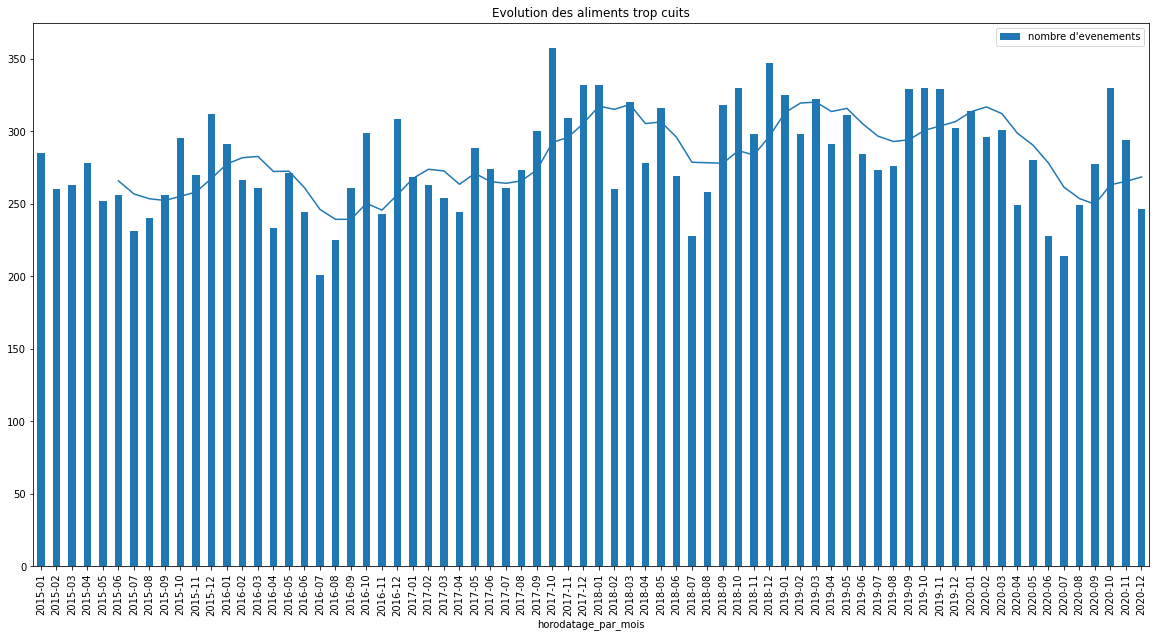

In [308]:
overcooked = final_data[final_data["type_incident"] == "Aliments surchauffés"][["horodatage", "horodatage_par_mois", "type_incident"]].copy()
overcooked = overcooked.drop('type_incident', axis=1).groupby("horodatage_par_mois").count().rename(columns={'horodatage': "nombre d'evenements"})
overcooked.plot(kind='bar')
plt.plot(overcooked.rolling(6).mean().values)
plt.title("Evolution des aliments trop cuits")
plt.show()

# Arrondissements

Text(0.5, 1.0, "Nombre d'évènements par arrondissement sur la période 2015-2020")

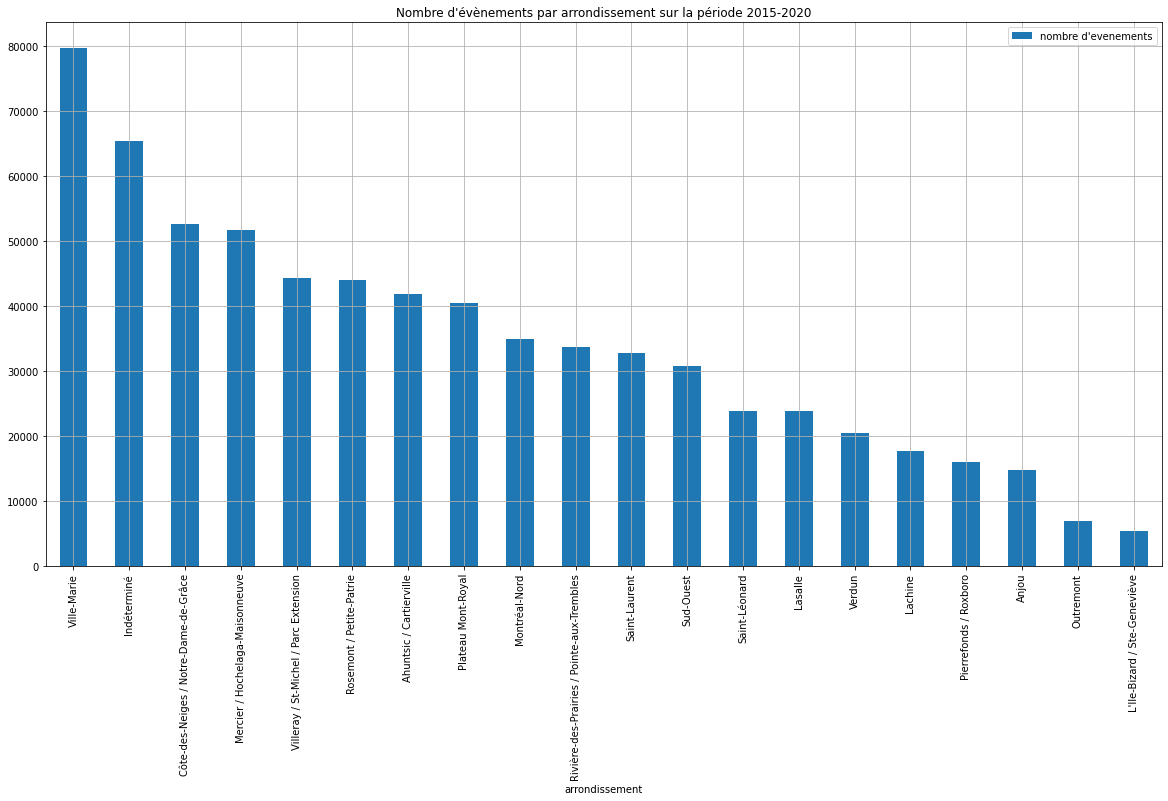

In [310]:
count_per_arron = (final_data.groupby("arrondissement").count()
 .rename(columns={"horodatage": "nombre d'evenements"})
 .drop([col for col in final_data.columns if col not in ["arrondissement", "horodatage"]], axis=1)
 .sort_values(by="nombre d'evenements", ascending=False)
)
count_per_arron.plot(kind="bar")
plt.grid()
plt.title("Nombre d'évènements par arrondissement sur la période 2015-2020")

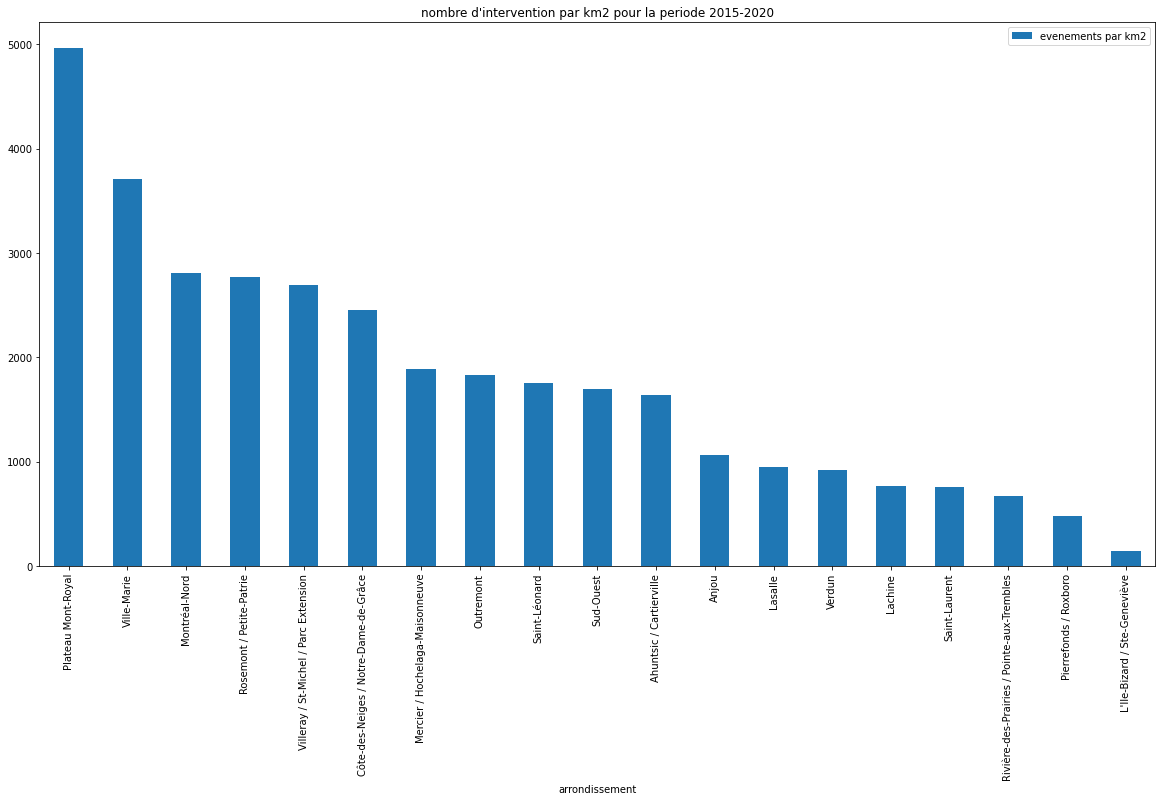

In [329]:
data = count_per_arron.join(arrondissement_geo, how='right')
data['evenements par km2'] = data["nombre d'evenements"] / data["arrondissement_aire_km2"]
data.drop(["nombre d'evenements", "arrondissement_aire_km2"], axis=1, inplace=True)
data.sort_values(by="evenements par km2", inplace=True, ascending=False)
data.plot(kind="bar")
plt.title("nombre d'intervention par km2 pour la periode 2015-2020")
plt.xlabel("arrondissement")
plt.show()

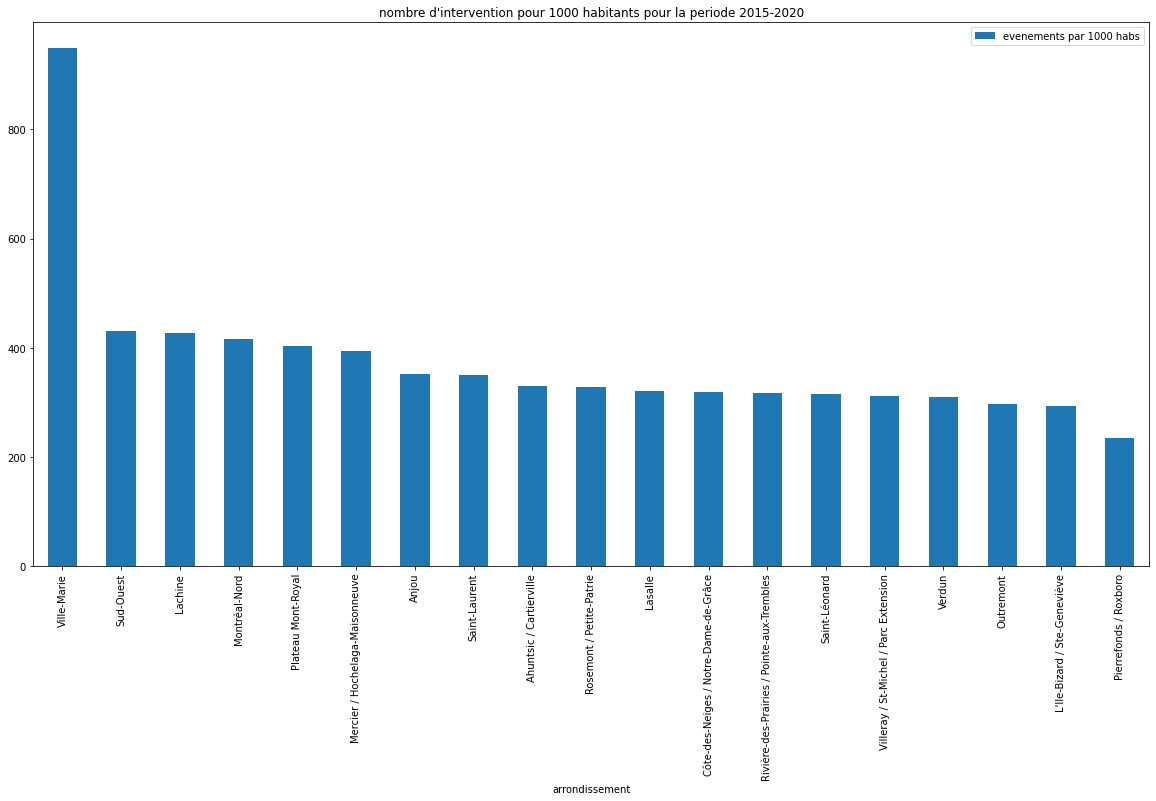

In [335]:
data = count_per_arron.join(arrondissement_pop, how='right')
data['evenements par 1000 habs'] = data["nombre d'evenements"] / data["arrondissement_population"] * 1000
data.drop(["nombre d'evenements", "arrondissement_population"], axis=1, inplace=True)
data.sort_values(by="evenements par 1000 habs", inplace=True, ascending=False)
data.plot(kind="bar")
plt.title("nombre d'intervention pour 1000 habitants pour la periode 2015-2020")
plt.xlabel("arrondissement")
plt.show()